In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import re, copy

SEASON_SPLIT = 2024

## Reading in data from csv files

In [2]:
matches = pd.read_csv('matches.csv', index_col=0)
print(matches.shape)

(2955, 40)


In [32]:
next_matches = pd.read_csv('next_matches.csv', index_col=0)
print(next_matches.shape)

(20, 22)


In [4]:
history_matches = pd.read_csv('history.csv', index_col=0)
print(history_matches.shape)

(44647, 16)


In [5]:
odds_matches_2026 = pd.read_csv('odds/2026_prem.csv', index_col=0)
odds_matches_2025 = pd.read_csv('odds/2025_prem.csv', index_col=0)
odds_matches_2024 = pd.read_csv('odds/2024_prem.csv', index_col=0)
odds_matches_2023 = pd.read_csv('odds/2023_prem.csv', index_col=0)
odds_matches = pd.concat([odds_matches_2026, odds_matches_2025, odds_matches_2024, odds_matches_2023])

In [6]:
# getting the matches of the desired league
LEAGUE = 'Premier League'
league_matches = matches[matches['Comp'] == LEAGUE]
league_history_matches = history_matches[history_matches['Comp'] == LEAGUE]
league_matches.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,2CrdY,Fls,Fld,Off,Crs,Int,TklW,Won%,SCA,GCA
1,2025-08-15,20:00 (05:00),Premier League,Matchweek 1,Fri,Home,W,4,2,Bournemouth,...,0.0,7.0,10.0,2.0,17.0,4.0,13.0,61.7,36.0,7.0
2,2025-08-25,20:00 (05:00),Premier League,Matchweek 2,Mon,Away,W,3,2,Newcastle Utd,...,0.0,15.0,16.0,0.0,9.0,0.0,8.0,51.5,9.0,6.0
3,2025-08-31,16:30 (01:30),Premier League,Matchweek 3,Sun,Home,W,1,0,Arsenal,...,0.0,7.0,10.0,1.0,7.0,7.0,9.0,55.6,16.0,2.0
4,2025-08-17,14:00 (23:00),Premier League,Matchweek 1,Sun,Home,D,0,0,Crystal Palace,...,0.0,10.0,10.0,0.0,29.0,11.0,6.0,51.5,31.0,0.0
5,2025-08-22,20:00 (05:00),Premier League,Matchweek 2,Fri,Away,W,5,1,West Ham,...,0.0,10.0,7.0,2.0,15.0,4.0,13.0,51.7,20.0,9.0


## Date Exploration and Analysis

In [7]:
league_matches['Team'].value_counts()

Team
Liverpool                   117
Chelsea                     117
Arsenal                     117
Tottenham Hotspur           117
Everton                     117
Bournemouth                 117
Crystal Palace              117
Manchester United           117
Nottingham Forest           117
Wolverhampton Wanderers     117
Brighton and Hove Albion    117
Manchester City             117
Brentford                   117
Newcastle United            117
West Ham United             117
Aston Villa                 117
Fulham                      117
Southampton                  76
Leicester City               76
Burnley                      41
Leeds United                 41
Luton Town                   38
Ipswich Town                 38
Sheffield United             38
Sunderland                    3
Name: count, dtype: int64

In [8]:
league_matches['Opponent'].value_counts()

Opponent
Bournemouth        117
Newcastle Utd      117
Arsenal            117
Crystal Palace     117
West Ham           117
Fulham             117
Manchester Utd     117
Liverpool          117
Manchester City    117
Everton            117
Brighton           117
Wolves             117
Brentford          117
Chelsea            117
Tottenham          117
Nott'ham Forest    117
Aston Villa        117
Southampton         76
Leicester City      76
Leeds United        41
Burnley             41
Sheffield Utd       38
Ipswich Town        38
Luton Town          38
Sunderland           3
Name: count, dtype: int64

In [9]:
league_matches.dtypes

Date              object
Time              object
Comp              object
Round             object
Day               object
Venue             object
Result            object
GF                object
GA                object
Opponent          object
xG               float64
xGA              float64
Poss             float64
Attendance       float64
Captain           object
Formation         object
Opp Formation     object
Referee           object
Match Report      object
Notes             object
Season             int64
Team              object
Sh               float64
SoT              float64
Dist             float64
FK               float64
PK               float64
PKatt            float64
CrdY             float64
CrdR             float64
2CrdY            float64
Fls              float64
Fld              float64
Off              float64
Crs              float64
Int              float64
TklW             float64
Won%             float64
SCA              float64
GCA              float64


In [10]:
team_names = sorted(league_matches['Team'].unique())
opp_names = sorted(league_matches['Opponent'].unique())

exculsive_team_names = []
exculsive_opp_names = []

# finding out the team names that are written differently in the opponent column
for i in team_names:
    if (i not in opp_names):
        exculsive_team_names.append(i)
        print(i)

print('---------------------------')

for i in opp_names:
    if (i not in team_names):
        exculsive_opp_names.append(i)
        print(i)

Brighton and Hove Albion
Manchester United
Newcastle United
Nottingham Forest
Sheffield United
Tottenham Hotspur
West Ham United
Wolverhampton Wanderers
---------------------------
Brighton
Manchester Utd
Newcastle Utd
Nott'ham Forest
Sheffield Utd
Tottenham
West Ham
Wolves


In [11]:
team_names = set(odds_matches['HomeTeam']) | set(odds_matches['AwayTeam'])
team_names = sorted(team_names)
for team_name in team_names:
    if team_name not in league_history_matches['Home'].unique() and team_name not in league_history_matches['Away'].unique():
        print(team_name)
        exculsive_team_names.append(team_name)

Ipswich
Leeds
Leicester
Luton
Man City
Man United
Newcastle
Nott'm Forest
Sheffield United


In [12]:
odds_missing_opp_names = ['Ipswich Town', 'Leeds United', 'Leicester City',
                          'Luton Town', 'Manchester City', 'Manchester Utd',
                          'Newcastle Utd', "Nott'ham Forest", 'Sheffield Utd']

In [13]:
sorted(league_history_matches['Home'].unique())

['Arsenal',
 'Aston Villa',
 'Barnsley',
 'Birmingham City',
 'Blackburn',
 'Blackpool',
 'Bolton',
 'Bournemouth',
 'Bradford City',
 'Brentford',
 'Brighton',
 'Burnley',
 'Cardiff City',
 'Charlton Ath',
 'Chelsea',
 'Coventry City',
 'Crystal Palace',
 'Derby County',
 'Everton',
 'Fulham',
 'Huddersfield',
 'Hull City',
 'Ipswich Town',
 'Leeds United',
 'Leicester City',
 'Liverpool',
 'Luton Town',
 'Manchester City',
 'Manchester Utd',
 'Middlesbrough',
 'Newcastle Utd',
 'Norwich City',
 "Nott'ham Forest",
 'Portsmouth',
 'QPR',
 'Reading',
 'Sheffield Utd',
 'Sheffield Weds',
 'Southampton',
 'Stoke City',
 'Sunderland',
 'Swansea City',
 'Tottenham',
 'Watford',
 'West Brom',
 'West Ham',
 'Wigan Athletic',
 'Wolves']

In [14]:
exculsive_opp_names.extend(odds_missing_opp_names)

In [15]:
# creating class to map team names written differently in opponent column to 
# corresponding team names.
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {}

for team_name, opp_name in zip(exculsive_team_names, exculsive_opp_names):
    map_values[team_name] = opp_name

mapping = MissingDict(**map_values)

In [16]:
odds_matches['Date'] = pd.to_datetime(odds_matches['Date'], dayfirst=True)
odds_matches['HomeTeam'] = odds_matches['HomeTeam'].map(mapping)
odds_matches['AwayTeam'] = odds_matches['AwayTeam'].map(mapping)
odds_matches = odds_matches[['Date', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 
                             'B365A', 'PSH', 'PSD',
                             'PSA', 'AvgH', 'AvgD', 'AvgA']]

In [17]:
odds_matches.to_csv('new.csv')

In [18]:
# applying mapping to ensure consistent team names
matches['Team'] = matches['Team'].map(mapping)
# creating a dictionary of team codes to ensure consistent team codes for each
# team
team_mapping_dict = {key: value for key, value in zip(matches['Team'], matches['Team'].astype('category').cat.codes)}
matches['Team_code'] = matches['Team'].map(team_mapping_dict)
matches['Opp_code'] = matches['Opponent'].map(team_mapping_dict)

# simplifying date and venue into respective codes
matches['Date'] = pd.to_datetime(matches['Date'])
matches['Venue_code'] = matches['Venue'].astype('category').cat.codes
matches['Hour'] = matches['Time'].str.replace(":.+", "", regex=True).astype('int')
matches['Day_code'] = matches['Date'].dt.dayofweek

matches['Target'] = matches['Result'].astype('category').cat.codes

matches['GF'] = matches['GF'].apply(lambda x: int(re.search(r'^[0-9]+', x).group(0)))
matches['GA'] = matches['GA'].apply(lambda x: int(re.search(r'^[0-9]+', str(x)).group(0)))

In [23]:
matches_copy1 = matches.merge(odds_matches, how='left', left_on=['Date', 'Team', 'Opponent'],
                        right_on=['Date', 'HomeTeam', 'AwayTeam'])
matches_copy2 = matches.merge(odds_matches, how='left', left_on=['Date', 'Opponent', 'Team'],
                        right_on=['Date', 'HomeTeam', 'AwayTeam'])
matches = matches_copy1.combine_first(matches_copy2)

In [24]:
matches.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,AwayTeam,B365H,B365D,B365A,PSH,PSD,PSA,AvgH,AvgD,AvgA
0,2025-08-10,15:00 (00:00),FA Community Shield,FA Community Shield,Sun,Neutral,D,2,2,Crystal Palace,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-08-15,20:00 (05:00),Premier League,Matchweek 1,Fri,Home,W,4,2,Bournemouth,...,Bournemouth,1.30,6.00,8.50,1.28,6.56,9.07,1.31,5.96,8.31
2,2025-08-25,20:00 (05:00),Premier League,Matchweek 2,Mon,Away,W,3,2,Newcastle Utd,...,Liverpool,3.25,3.80,2.05,3.29,3.92,2.11,3.30,3.83,2.02
3,2025-08-31,16:30 (01:30),Premier League,Matchweek 3,Sun,Home,W,1,0,Arsenal,...,Arsenal,2.20,3.50,3.20,2.27,3.47,3.28,2.20,3.49,3.17
4,2025-08-17,14:00 (23:00),Premier League,Matchweek 1,Sun,Home,D,0,0,Crystal Palace,...,Crystal Palace,1.62,4.33,4.50,1.66,4.12,5.25,1.61,4.21,5.08


In [25]:
matches = matches.drop(columns=['Time', 'Day', 'Result', 'Attendance',
                                'Match Report', 'Notes','Captain', 'Formation',
                                'Opp Formation', 'Referee', 'HomeTeam', 'AwayTeam'])

In [26]:
matches.dtypes

Date          datetime64[ns]
Comp                  object
Round                 object
Venue                 object
GF                     int64
GA                     int64
Opponent              object
xG                   float64
xGA                  float64
Poss                 float64
Season                 int64
Team                  object
Sh                   float64
SoT                  float64
Dist                 float64
FK                   float64
PK                   float64
PKatt                float64
CrdY                 float64
CrdR                 float64
2CrdY                float64
Fls                  float64
Fld                  float64
Off                  float64
Crs                  float64
Int                  float64
TklW                 float64
Won%                 float64
SCA                  float64
GCA                  float64
Team_code              int64
Opp_code             float64
Venue_code              int8
Hour                   int64
Day_code      

In [27]:
matches['Target'].value_counts()

Target
2    1253
1    1057
0     645
Name: count, dtype: int64

In [33]:
next_matches['Team'] = next_matches['Team'].map(mapping)
next_matches['Team_code'] = next_matches['Team'].map(team_mapping_dict)
next_matches['Opp_code'] = next_matches['Opponent'].map(team_mapping_dict)

next_matches['Date'] = pd.to_datetime(next_matches['Date'])
next_matches['Venue_code'] = next_matches['Venue'].astype('category').cat.codes
next_matches['Hour'] = next_matches['Time'].str.replace(":.+", "", regex=True).astype('int')
next_matches['Day_code'] = next_matches['Date'].dt.dayofweek

In [34]:
next_matches_copy1 = next_matches.merge(odds_matches, how='left', left_on=['Date', 'Team', 'Opponent'],
                        right_on=['Date', 'HomeTeam', 'AwayTeam'])
next_matches_copy2 = next_matches.merge(odds_matches, how='left', left_on=['Date', 'Opponent', 'Team'],
                        right_on=['Date', 'HomeTeam', 'AwayTeam'])
next_matches = next_matches_copy1.combine_first(next_matches_copy2)

In [35]:
next_matches = next_matches.drop(columns=['Time', 'Day', 'Venue', 'Result', 
                                          'Attendance', 'Match Report', 'Notes',
                                          'Captain', 'Formation',
                                          'Opp Formation', 'Referee', 'HomeTeam', 'AwayTeam'])

In [36]:
next_matches.dtypes

Date          datetime64[ns]
Comp                  object
Round                 object
GF                   float64
GA                   float64
Opponent              object
xG                   float64
xGA                  float64
Poss                 float64
Season                 int64
Team                  object
Team_code              int64
Opp_code               int64
Venue_code              int8
Hour                   int64
Day_code               int32
B365H                float64
B365D                float64
B365A                float64
PSH                  float64
PSD                  float64
PSA                  float64
AvgH                 float64
AvgD                 float64
AvgA                 float64
dtype: object

In [37]:
def get_Target(row):
    if row['GF'] > row['GA']:
        return 2
    elif row['GF'] < row['GA']:
        return 1
    else:
        return 0

In [38]:
history_matches['Team'] = history_matches['Team'].map(mapping)
history_matches['Date'] = pd.to_datetime(history_matches['Date'])
history_matches['GF'] = history_matches['Score'].apply(lambda score: (score.split('–')[0]))
history_matches['GA'] = history_matches['Score'].apply(lambda score: score.split('–')[1])
history_matches['GF'] = history_matches['GF'].apply(lambda x: int(re.search(r'[0-9]+$', x).group(0)))
history_matches['GA'] = history_matches['GA'].apply(lambda x: int(re.search(r'^[0-9]+', x).group(0)))
history_matches['Target'] = history_matches.apply(get_Target, axis=1)

In [40]:
history_matches_copy1 = history_matches.merge(odds_matches, how='left', left_on=['Date', 'Team', 'Away'],
                        right_on=['Date', 'HomeTeam', 'AwayTeam'])
history_matches_copy2 = history_matches.merge(odds_matches, how='left', left_on=['Date', 'Away', 'Team'],
                        right_on=['Date', 'HomeTeam', 'AwayTeam'])
history_matches = history_matches_copy1.combine_first(history_matches_copy2)

In [41]:
history_matches = history_matches.drop(columns=['Time', 'Day', 'Venue', 
                                                'Attendance', 'Match Report', 
                                                'Notes', 'Referee',
                                                'Home', 'Away', 'HomeTeam', 'AwayTeam'])

In [42]:
history_matches.dtypes

Comp              object
Round             object
Date      datetime64[ns]
xG               float64
Score             object
xG.1             float64
Team              object
GF                 int64
GA                 int64
Target             int64
B365H            float64
B365D            float64
B365A            float64
PSH              float64
PSD              float64
PSA              float64
AvgH             float64
AvgD             float64
AvgA             float64
dtype: object

In [44]:
# function to compute rolling averages of given columns for each match
def rolling_avgs(group, cols, new_cols, num_past_matches_considered=3):
    group = group.sort_values('Date')
    rolling_stats = group[cols].rolling(num_past_matches_considered, 
                                        closed='left', min_periods=1).mean()
    group[new_cols] = rolling_stats.fillna(0)
    return group

In [45]:
# rolling avgs for matches across the desired league
league_ravg_cols = ['GF', 'GA', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 
             'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%',
             'SCA', 'GCA', 'xG', 'xGA']
league_ravg_new_cols = [f"{c}league_rolling" for c in league_ravg_cols]

In [46]:
# stats for last match
last_ravg_cols = ['GF', 'GA', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 
             'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%',
             'SCA', 'GCA', 'xG', 'xGA', 'Target']
last_ravg_new_cols = [f"{c}last_rolling" for c in last_ravg_cols]

In [47]:
# rolling avgs for matches across all head to head matches
hth_ravg_cols = ['xG', 'xG.1', 'GF', 'GA']
hth_ravg_new_cols = [f"{c}hth_rolling" for c in hth_ravg_cols]

In [48]:
def rolling_avg_match_rest(group, num_past_matches_considered=3):
    group['days_diff'] = group['Date'].diff().dt.days
    rolling_stats = group['days_diff'].rolling(num_past_matches_considered, 
                                        closed='left', min_periods=1).mean()
    group[f'rolling_rests_{num_past_matches_considered}'] = rolling_stats.fillna(0)
    return group

In [49]:
def rolling_match_results(group, name, num_past_matches_considered=3):
    group['is_win'] = (group['Target'] == 2).astype(int)
    rolling_stats = group['is_win'].rolling(num_past_matches_considered, 
                                        closed='left', min_periods=1).sum()
    group[f'{name}num_wins_rolling'] = rolling_stats.fillna(0)
    return group

In [50]:
all_matches = pd.concat([matches, next_matches])
all_matches = all_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avg_match_rest(x),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
league_matches = all_matches[all_matches['Comp'] == LEAGUE]
team_league_matches = league_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avgs(x, league_ravg_cols, league_ravg_new_cols),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
team_league_matches = team_league_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_match_results(x, 'league'),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
# team_matches = team_matches.droplevel('Team')
# team_matches.index = range(team_matches.shape[0])
team_last_matches = all_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avg_match_rest(x,1),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
team_last_matches = team_last_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avgs(x, last_ravg_cols, last_ravg_new_cols,1),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
hth_and_next_matches = pd.concat([history_matches, next_matches])
team_hth_matches = hth_and_next_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avgs(x, hth_ravg_cols, hth_ravg_new_cols),
                                                                               include_groups=False).reset_index(level=0).reset_index(drop=True)

team_hth_matches = team_hth_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_match_results(x, 'hth'),
                                                                               include_groups=False).reset_index(level=0).reset_index(drop=True)


In [51]:
opp_team_league_matches = team_league_matches.copy()
opp_team_league_matches = opp_team_league_matches.add_prefix('Opp_')

opp_team_last_matches = team_last_matches.copy()
opp_team_last_matches = opp_team_last_matches.add_prefix('Opp_')

In [52]:
team_league_matches = team_league_matches.merge(opp_team_league_matches,
                                         left_on=['Date', 'Opponent'],
                                         right_on=['Opp_Date', 'Opp_Team'],
                                         how='left')
team_league_matches = team_league_matches.drop(columns=['Opp_Date', 'Opp_Team', 'Opp_Comp', 'Opp_Round',
                                  'Opp_GF', 'Opp_GA', 'Opp_Opponent','Opp_xG',
                                  'Opp_xGA', 'Opp_Season', 'Opp_Team_code', 'Opp_Opp_code',
                                  'Opp_Venue_code', 'Opp_Hour', 'Opp_Day_code',
                                  'Opp_Target', 'Opp_days_diff', 'Opp_is_win'])
team_last_matches = team_last_matches.merge(opp_team_last_matches,
                                         left_on=['Date', 'Opponent'],
                                         right_on=['Opp_Date', 'Opp_Team'],
                                         how='left')
team_last_matches = team_last_matches.drop(columns=['Opp_Date', 'Opp_Team', 'Opp_Comp', 'Opp_Round',
                                  'Opp_GF', 'Opp_GA', 'Opp_Opponent','Opp_xG',
                                  'Opp_xGA', 'Opp_Season', 'Opp_Team_code', 'Opp_Opp_code',
                                  'Opp_Venue_code', 'Opp_Hour', 'Opp_Day_code',
                                  'Opp_days_diff'])

In [53]:
last_ravg_new_cols_merge = copy.deepcopy(last_ravg_new_cols)
hth_ravg_new_cols_merge = copy.deepcopy(hth_ravg_new_cols)
last_ravg_new_cols_merge = last_ravg_new_cols_merge + ['Opp_' + column for column in last_ravg_new_cols_merge]
last_ravg_new_cols_merge.append('Date')
hth_ravg_new_cols_merge.append('Date')
last_ravg_new_cols_merge.append('Team')
hth_ravg_new_cols_merge.append('Team')
last_ravg_new_cols_merge.append('rolling_rests_1')
last_ravg_new_cols_merge.append('Opp_rolling_rests_1')
hth_ravg_new_cols_merge.append('hthnum_wins_rolling')
team_matches = team_league_matches.merge(team_last_matches[last_ravg_new_cols_merge],
                                                on=['Date', 'Team'], how='left')
team_matches = team_matches.merge(team_hth_matches[hth_ravg_new_cols_merge],
                                                on=['Date', 'Team'], how='left')

In [54]:
team_matches = team_matches[team_matches['Comp'] == LEAGUE]

In [55]:
team_matches.shape

(2360, 177)

In [59]:
print(list(team_matches.columns))

['Team', 'Date', 'Comp', 'Round', 'Venue', 'GF', 'GA', 'Opponent', 'xG', 'xGA', 'Poss', 'Season', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%', 'SCA', 'GCA', 'Team_code', 'Opp_code', 'Venue_code', 'Hour', 'Day_code', 'Target', 'B365H', 'B365D', 'B365A', 'PSH', 'PSD', 'PSA', 'AvgH', 'AvgD', 'AvgA', 'days_diff', 'rolling_rests_3', 'GFleague_rolling', 'GAleague_rolling', 'Shleague_rolling', 'SoTleague_rolling', 'Distleague_rolling', 'FKleague_rolling', 'PKleague_rolling', 'PKattleague_rolling', 'CrdYleague_rolling', 'CrdRleague_rolling', '2CrdYleague_rolling', 'Flsleague_rolling', 'Fldleague_rolling', 'Offleague_rolling', 'Crsleague_rolling', 'Intleague_rolling', 'TklWleague_rolling', 'Won%league_rolling', 'SCAleague_rolling', 'GCAleague_rolling', 'xGleague_rolling', 'xGAleague_rolling', 'is_win', 'leaguenum_wins_rolling', 'Opp_Venue', 'Opp_Poss', 'Opp_Sh', 'Opp_SoT', 'Opp_Dist', 'Opp_FK', 'Opp_PK', 'Opp_PKatt', 'Opp_

In [60]:
sorted_round = sorted(team_matches['Round'].unique(), key=lambda round:int((re.search('[0-9]+$', round)).group(0)))
round_mapping_dict = {value: key for key, value in enumerate(sorted_round, start=1)}
team_matches['Round'] = team_matches['Round'].map(round_mapping_dict)

In [61]:
# add ranking of the teams at each match
team_matches = team_matches.sort_values('Date').reset_index(drop=True)

curr_season = 0
for season_gameweek, stats in team_matches.groupby(['Season', 'Round'], sort=True):
    if curr_season != season_gameweek[0]:
        curr_season = season_gameweek[0]
        standings = defaultdict(lambda : {'points': 0, 'goal_diff': 0, 'GF': 0})

    sorted_standings = sorted(standings.items(), 
                              key=lambda x: (-x[1]['points'], -x[1]['goal_diff'], -x[1]['GF'], x[0]))
    ranking = {team: pos for pos, (team, stats) in enumerate(sorted_standings, start=1)}
    
    # setting current league position
    for index, row in stats.iterrows():
        team_matches.at[index, 'Team_position'] = ranking.get(row['Team'], 0)
        team_matches.at[index, 'Opp_position'] = ranking.get(row['Opponent'], 0)

    # updating ranking data
    for index, row in stats.iterrows():
        goals_for = row['GF']
        goals_against = row['GA']
        standings[row['Team']]['GF'] += goals_for
        standings[row['Team']]['goal_diff'] += goals_for - goals_against
        
        if goals_for > goals_against:
            standings[row['Team']]['points'] += 3
        elif goals_for < goals_against:
            standings[row['Team']]['points'] += 0
        else:
            standings[row['Team']]['points'] += 1

team_matches

,Team,Date,Comp,Round,Venue,GF,GA,Opponent,xG,xGA,...,Opp_Targetlast_rolling,rolling_rests_1,Opp_rolling_rests_1,xGhth_rolling,xG.1hth_rolling,GFhth_rolling,GAhth_rolling,hthnum_wins_rolling,Team_position,Opp_position
0,Arsenal,2022-08-05,Premier League,1,Away,2.0,0.0,Crystal Palace,1.0,1.2,...,0.0,7.0,8.0,2.833333,0.733333,3.333333,0.333333,3.0,0.0,0.0
1,Crystal Palace,2022-08-05,Premier League,1,Home,0.0,2.0,Arsenal,1.2,1.0,...,0.0,8.0,7.0,0.800000,1.066667,1.666667,1.000000,2.0,0.0,0.0
2,Southampton,2022-08-06,Premier League,1,Away,1.0,4.0,Tottenham,0.5,1.5,...,0.0,7.0,5.0,2.033333,1.266667,2.666667,1.000000,2.0,0.0,0.0
3,Aston Villa,2022-08-06,Premier League,1,Away,0.0,2.0,Bournemouth,0.7,0.6,...,0.0,6.0,8.0,1.966667,1.066667,1.666667,1.333333,1.0,0.0,0.0
4,Liverpool,2022-08-06,Premier League,1,Away,2.0,2.0,Fulham,1.2,1.2,...,0.0,-659.0,8.0,2.450000,1.100000,2.000000,1.000000,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2355,Wolves,2025-09-13,Premier League,4,NaN,NaN,NaN,Newcastle Utd,NaN,NaN,...,0.0,8.0,6.0,1.200000,1.200000,2.000000,1.666667,2.0,20.0,17.0
2356,Burnley,2025-09-14,Premier League,4,NaN,NaN,NaN,Liverpool,NaN,NaN,...,2.0,8.0,8.0,2.300000,1.000000,2.333333,1.000000,3.0,14.0,1.0
2357,Liverpool,2025-09-14,Premier League,4,NaN,NaN,NaN,Burnley,NaN,NaN,...,1.0,8.0,8.0,1.233333,0.966667,2.333333,1.666667,2.0,1.0,14.0
2358,Manchester City,2025-09-14,Premier League,4,NaN,NaN,NaN,Manchester Utd,NaN,NaN,...,2.0,7.0,6.0,1.466667,1.766667,0.666667,2.333333,1.0,13.0,9.0


In [63]:
team_matches['Match_key'] = team_matches.apply(lambda row: tuple(sorted([row['Team'], row['Opponent']])), axis=1)

team_matches = team_matches.drop_duplicates(subset=['Match_key', 'Date'])
team_matches = team_matches.drop(columns=['Match_key'])

In [64]:
team_matches.shape

(1180, 179)

In [65]:
INITIAL_ATTACK_STRENGTH = 0
INITIAL_DEFENSE_STRENGTH = 0
HOME_ADVANTAGE_ADDITION = 0.2
LEARNING_RATE = 0.05

team_attack_strengths = defaultdict(lambda: INITIAL_ATTACK_STRENGTH)
team_defense_strengths = defaultdict(lambda: INITIAL_DEFENSE_STRENGTH)

def get_expected_goal(team, opp):
    expected_goal_team = np.exp(team_attack_strengths[team] - team_defense_strengths[opp] + HOME_ADVANTAGE_ADDITION)
    expected_goal_opp = np.exp(team_attack_strengths[opp] - team_defense_strengths[team])
    return (expected_goal_team, expected_goal_opp)

def update_strengths(team, opp, team_goals, opp_goals, team_xg, opp_xg):
    team_attack_strengths[team] += LEARNING_RATE * (team_goals - team_xg)
    team_defense_strengths[team] += LEARNING_RATE * (opp_xg - opp_goals)

    team_attack_strengths[opp] += LEARNING_RATE * (opp_goals - opp_xg)
    team_defense_strengths[opp] += LEARNING_RATE * (team_xg - team_goals)
    
relative_attack_strength, relative_defense_strength = [], []
expected_goal_team, expected_goal_opp = [], []

for index, row in team_matches.iterrows():
    ex_goal_team, ex_goal_opp = get_expected_goal(row['Team'], row['Opponent'])
    expected_goal_team.append(ex_goal_team)
    expected_goal_opp.append(ex_goal_opp)

    relative_attack_strength.append(team_attack_strengths[row['Team']] - team_attack_strengths[row['Opponent']])
    relative_defense_strength.append(team_defense_strengths[row['Team']] - team_defense_strengths[row['Opponent']])

    update_strengths(row['Team'], row['Opponent'], row['GF'],
                   row['GA'], row['xG'], row['xGA'])
    
team_matches['Expected_goal_team'] = expected_goal_team
team_matches['Expected_goal_opp'] = expected_goal_opp
team_matches['Relative_attack_strength'] = relative_attack_strength
team_matches['Relative_defense_strength'] = relative_defense_strength

In [66]:
total_goals_mean = (team_matches['GF'].sum() + team_matches['GA'].sum()) / team_matches.shape[0]
expected_goals_mean = (team_matches['Expected_goal_team'].sum() + team_matches['Expected_goal_team'].sum()) / team_matches.shape[0]
expected_goal_scale = total_goals_mean / expected_goals_mean

team_matches['Expected_goal_team'] *= expected_goal_scale
team_matches['Expected_goal_opp'] *= expected_goal_scale

In [67]:
import numpy as np
from scipy.stats import poisson

def match_outcome_probs(lam_team, lam_opp, max_goals=10):
    # Scoreline probability matrix
    probs = np.zeros((max_goals, max_goals))
    for i in range(max_goals):
        for j in range(max_goals):
            probs[i, j] = poisson.pmf(i, lam_team) * poisson.pmf(j, lam_opp)
    
    # Probabilities of outcomes
    p_team_win = np.sum(np.tril(probs, -1))  # lower triangle, i > j
    p_draw     = np.sum(np.diag(probs))      # diagonal, i = j
    p_opp_win = np.sum(np.triu(probs, 1))   # upper triangle, i < j
    
    return p_team_win, p_draw, p_opp_win

team_matches[['Predicted_team_win', 'Predicted_team_draw', 
              'Predicted_team_loss']] = team_matches.apply(lambda row: match_outcome_probs(row["Expected_goal_team"], row["Expected_goal_opp"]), axis=1, result_type='expand')

In [68]:
K = 20
HOME_ADVANTAGE = 40
SCALING = 400

team_ratings = defaultdict(lambda: 1500)

def get_expected_score(team_rating, opp_rating, venue):
    if venue == 'Home':
        h = HOME_ADVANTAGE 
    else:
        h = 0
    return 1 / (1 + 10 ** (-(team_rating - opp_rating + h) / SCALING))

def goal_diff_multiplier(team_goal, opp_goal):
    goal_diff = abs(team_goal - opp_goal)
    return np.log((goal_diff + 1) * (2.2 / (goal_diff + 2.2)))

def update_ratings(team, opp, team_goal, opp_goal, venue):
    if team_goal > opp_goal:
        team_result = 1
    elif team_goal == opp_goal:
        team_result = 0.5
    else:
        team_result = 0

    opp_result = 1 - team_result

    team_rating, opp_rating = team_ratings[team], team_ratings[opp]

    team_expected_result = get_expected_score(team_rating, opp_rating, venue)
    opp_expected_result = 1 - team_expected_result

    multiplier = goal_diff_multiplier(team_goal, opp_goal)

    team_ratings[team] += K * multiplier * (team_result - team_expected_result)
    team_ratings[opp] += K * multiplier * (opp_result - opp_expected_result)

ratings = []
for index, row in team_matches.iterrows():
    ratings.append(team_ratings[row['Team']] - team_ratings[row['Opponent']])
    update_ratings(row['Team'], row['Opponent'], row['GF'],
                             row['GA'], row['Venue'])
    
team_matches['Relative_ratings'] = ratings

In [69]:
team_matches

,Team,Date,Comp,Round,Venue,GF,GA,Opponent,xG,xGA,...,Team_position,Opp_position,Expected_goal_team,Expected_goal_opp,Relative_attack_strength,Relative_defense_strength,Predicted_team_win,Predicted_team_draw,Predicted_team_loss,Relative_ratings
0,Arsenal,2022-08-05,Premier League,1,Away,2.0,0.0,Crystal Palace,1.0,1.2,...,0.0,0.0,0.917166,0.750912,0.00,0.000,0.375420,0.342659,0.281921,0.000000
2,Southampton,2022-08-06,Premier League,1,Away,1.0,4.0,Tottenham,0.5,1.5,...,0.0,0.0,0.917166,0.750912,0.00,0.000,0.375420,0.342659,0.281921,0.000000
3,Aston Villa,2022-08-06,Premier League,1,Away,0.0,2.0,Bournemouth,0.7,0.6,...,0.0,0.0,0.917166,0.750912,0.00,0.000,0.375420,0.342659,0.281921,0.000000
4,Liverpool,2022-08-06,Premier League,1,Away,2.0,2.0,Fulham,1.2,1.2,...,0.0,0.0,0.917166,0.750912,0.00,0.000,0.375420,0.342659,0.281921,0.000000
5,Newcastle Utd,2022-08-06,Premier League,1,Home,2.0,0.0,Nott'ham Forest,1.7,0.3,...,0.0,0.0,0.917166,0.750912,0.00,0.000,0.375420,0.342659,0.281921,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,Fulham,2025-09-13,Premier League,4,NaN,NaN,NaN,Leeds United,NaN,NaN,...,18.0,12.0,3.813445,0.495857,0.89,0.950,0.921580,0.053726,0.018756,49.217522
2350,Brentford,2025-09-13,Premier League,4,NaN,NaN,NaN,Chelsea,NaN,NaN,...,15.0,2.0,0.885620,0.602621,0.89,-0.705,0.401196,0.363323,0.235481,-50.084539
2352,Newcastle Utd,2025-09-13,Premier League,4,NaN,NaN,NaN,Wolves,NaN,NaN,...,17.0,20.0,2.103354,0.908040,0.05,0.590,0.648855,0.198880,0.152195,128.944369
2356,Burnley,2025-09-14,Premier League,4,NaN,NaN,NaN,Liverpool,NaN,NaN,...,14.0,1.0,0.750912,1.810373,-0.45,-0.630,0.149984,0.223702,0.626293,-224.155050


In [70]:
team_matches['Target'].value_counts()

Target
2.0    468
1.0    434
0.0    268
Name: count, dtype: int64

In [71]:
def get_relative_feature(cols):
    relative_cols = []
    for col in cols:
        team_matches[f'Relative_{col}'] = team_matches[col] - team_matches[f'Opp_{col}']
        relative_cols.append(f'Relative_{col}')
    return relative_cols

In [72]:
relative_cols = get_relative_feature(league_ravg_new_cols)
relative_cols.extend(get_relative_feature(last_ravg_new_cols))
team_matches['Relative_pos'] = team_matches['Team_position'] - team_matches['Opp_position']
team_matches['Relative_rolling_rests_1'] = team_matches['rolling_rests_1'] - team_matches['Opp_rolling_rests_1']
team_matches['Relative_rolling_rests_3'] = team_matches['rolling_rests_3'] - team_matches['Opp_rolling_rests_3']
team_matches['Relative_leaguenum_wins_rolling'] = team_matches['leaguenum_wins_rolling'] - team_matches['Opp_leaguenum_wins_rolling']


In [73]:
columns_to_drop = ['Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 'CrdR', 
                   '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%', 
                   'SCA', 'GCA', 'Venue']
opp_columns_to_drop = ['Opp_' + column for column in columns_to_drop]
team_matches = team_matches.drop(columns=opp_columns_to_drop)
columns_to_drop.extend(['Team', 'Comp', 'Round', 'GF', 'GA', 
                        'Opponent', 'xG', 'xGA', 'days_diff', 'is_win'])
team_matches = team_matches.drop(columns=columns_to_drop) 


In [74]:
future_matches = team_matches[team_matches['Target'].isna()]
past_matches = team_matches[team_matches['Target'].notna()]

In [75]:
past_matches = past_matches[past_matches['AvgH'].notna()].copy()

In [76]:
print(future_matches.shape)
past_matches.shape

(10, 188)


(1170, 188)

In [54]:
past_matches.isnull().value_counts()

Date   Poss   Season  Team_code  Opp_code  Venue_code  Hour   Day_code  Target  rolling_rests_3  GFleague_rolling  GAleague_rolling  Shleague_rolling  SoTleague_rolling  Distleague_rolling  FKleague_rolling  PKleague_rolling  PKattleague_rolling  CrdYleague_rolling  CrdRleague_rolling  2CrdYleague_rolling  Flsleague_rolling  Fldleague_rolling  Offleague_rolling  Crsleague_rolling  Intleague_rolling  TklWleague_rolling  Won%league_rolling  SCAleague_rolling  GCAleague_rolling  xGleague_rolling  xGAleague_rolling  leaguenum_wins_rolling  Opp_Poss  Opp_rolling_rests_3  Opp_GFleague_rolling  Opp_GAleague_rolling  Opp_Shleague_rolling  Opp_SoTleague_rolling  Opp_Distleague_rolling  Opp_FKleague_rolling  Opp_PKleague_rolling  Opp_PKattleague_rolling  Opp_CrdYleague_rolling  Opp_CrdRleague_rolling  Opp_2CrdYleague_rolling  Opp_Flsleague_rolling  Opp_Fldleague_rolling  Opp_Offleague_rolling  Opp_Crsleague_rolling  Opp_Intleague_rolling  Opp_TklWleague_rolling  Opp_Won%league_rolling  Opp_SCAle

In [55]:
future_matches.isnull().value_counts()

Date   Poss  Season  Team_code  Opp_code  Venue_code  Hour   Day_code  Target  rolling_rests_3  GFleague_rolling  GAleague_rolling  Shleague_rolling  SoTleague_rolling  Distleague_rolling  FKleague_rolling  PKleague_rolling  PKattleague_rolling  CrdYleague_rolling  CrdRleague_rolling  2CrdYleague_rolling  Flsleague_rolling  Fldleague_rolling  Offleague_rolling  Crsleague_rolling  Intleague_rolling  TklWleague_rolling  Won%league_rolling  SCAleague_rolling  GCAleague_rolling  xGleague_rolling  xGAleague_rolling  leaguenum_wins_rolling  Opp_Poss  Opp_rolling_rests_3  Opp_GFleague_rolling  Opp_GAleague_rolling  Opp_Shleague_rolling  Opp_SoTleague_rolling  Opp_Distleague_rolling  Opp_FKleague_rolling  Opp_PKleague_rolling  Opp_PKattleague_rolling  Opp_CrdYleague_rolling  Opp_CrdRleague_rolling  Opp_2CrdYleague_rolling  Opp_Flsleague_rolling  Opp_Fldleague_rolling  Opp_Offleague_rolling  Opp_Crsleague_rolling  Opp_Intleague_rolling  Opp_TklWleague_rolling  Opp_Won%league_rolling  Opp_SCAlea

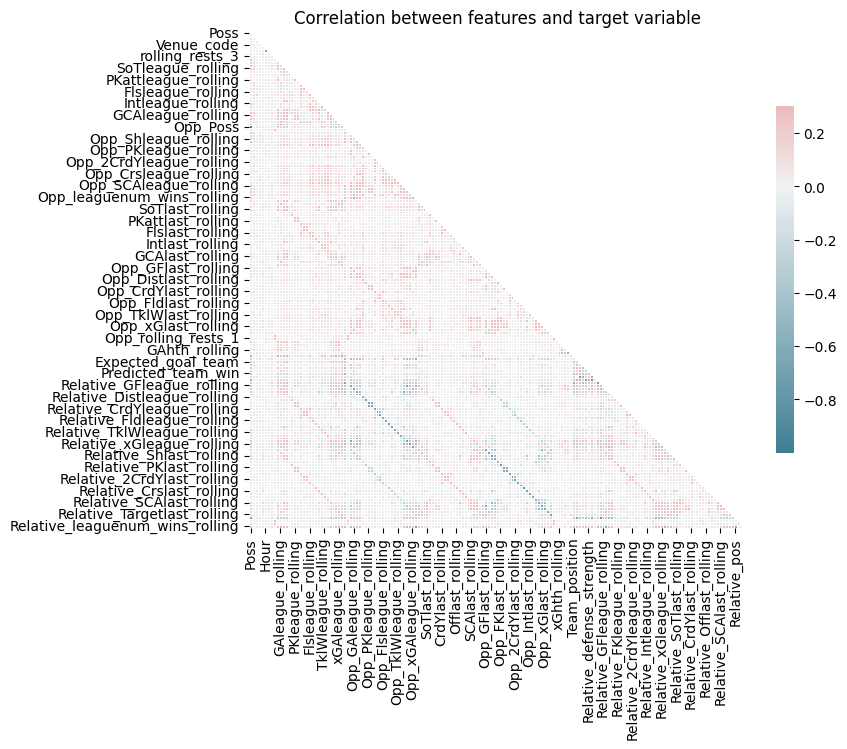

In [56]:
train = past_matches[past_matches['Season'] <= SEASON_SPLIT]
data = train.drop(columns=['Date'])

# compute the correlation matrix
corr_mat = data.corr()

# mask out upper triangle (correlation matrices are symmetric)
mask = np.zeros_like(corr_mat, dtype=bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(8, 9))
# generate custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)   
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation between features and target variable')
plt.show()

## Creating models and training

In [86]:
predictors = ['Team_code', 'Opp_code', 'Venue_code', 'Hour', 'Day_code']
additional_predictors = ['rolling_rests_1', 'rolling_rests_3',
                           'leaguenum_wins_rolling']
# predictors = predictors + league_ravg_new_cols + last_ravg_new_cols + hth_ravg_new_cols + additional_predictors
# predictors = predictors + ['Opp_' + column for column in league_ravg_new_cols]
# predictors = predictors + ['Opp_' + column for column in last_ravg_new_cols]
# predictors = predictors + ['Opp_' + column for column in additional_predictors]
predictors = predictors + ['Relative_pos', 'hthnum_wins_rolling',
                           'Relative_rolling_rests_1', 'Relative_rolling_rests_3',
                           'Relative_leaguenum_wins_rolling', 'Relative_attack_strength',
                           'Relative_defense_strength', 'Predicted_team_win', 'Predicted_team_draw', 
                            'Predicted_team_loss', 'Relative_ratings','B365H', 'B365D', 
                             'B365A', 'PSH', 'PSD',
                             'PSA', 'AvgH', 'AvgD', 'AvgA'
                            ]
predictors = predictors + relative_cols

train = past_matches[past_matches['Season'] <= SEASON_SPLIT]
val = train[train['Date'] >= '2024-03-14']
train = train[train['Date'] < '2024-03-14']
test = past_matches[past_matches['Season'] > SEASON_SPLIT]
train_X = train[predictors]
val_X = val[predictors]
test_X = test[predictors]
train_Y = train['Target']
val_Y = val['Target']
test_Y = test['Target']

In [87]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': np.arange(100, 200, 5), 
    'min_samples_split': np.arange(2,10),
    'max_depth': np.arange(2,10)
}

tscv = TimeSeriesSplit(n_splits=5)

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
clf.fit(train_X, train_Y)
refined_rf_model = clf.best_estimator_
preds = refined_rf_model.predict(test_X)
print(clf.best_params_)
print(classification_report(test_Y, preds, zero_division=0))

{'max_depth': np.int64(8), 'min_samples_split': np.int64(8), 'n_estimators': np.int64(100)}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        99
         1.0       0.54      0.67      0.60       152
         2.0       0.50      0.68      0.58       159

    accuracy                           0.51       410
   macro avg       0.35      0.45      0.39       410
weighted avg       0.39      0.51      0.44       410



0.0       0.00      0.00      0.00        99
         1.0       0.53      0.58      0.55       152
         2.0       0.48      0.74      0.58       159

    accuracy                           0.50       410
   macro avg       0.34      0.44      0.38       410
weighted avg       0.38      0.50      0.43       410

In [88]:
feature_importance = pd.Series(refined_rf_model.feature_importances_, index=train_X.columns).sort_values(ascending=False)
feature_importance

Relative_pos                    0.042248
Relative_ratings                0.039176
Relative_xGleague_rolling       0.031523
Relative_SCAleague_rolling      0.027760
PSD                             0.027146
                                  ...   
Relative_PKlast_rolling         0.003504
Relative_PKattlast_rolling      0.002545
Relative_2CrdYleague_rolling    0.002379
Relative_2CrdYlast_rolling      0.001590
Relative_CrdRlast_rolling       0.001482
Length: 70, dtype: float64

In [89]:
THRESHOLD = 0.015
selected_features = feature_importance[feature_importance >= THRESHOLD].index
print(len(selected_features))
train_X_selected = train_X[selected_features]
test_X_selected = test_X[selected_features]

26


In [91]:
result = permutation_importance(refined_rf_model, val_X, val_Y, n_repeats=10, random_state=42)

# Convert to DataFrame
importances_df = pd.DataFrame({
    "feature": val_X.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

non_zero_importances = importances_df[importances_df['importance_mean'] > 0.008]

print(non_zero_importances)

                       feature  importance_mean  importance_std
15            Relative_ratings         0.031683        0.017034
5                 Relative_pos         0.029703        0.020768
65    Relative_SCAlast_rolling         0.022772        0.008911
50    Relative_SoTlast_rolling         0.021782        0.008631
49     Relative_Shlast_rolling         0.021782        0.007409
27   Relative_Shleague_rolling         0.015842        0.009074
2                   Venue_code         0.012871        0.009950
25   Relative_GFleague_rolling         0.012871        0.008911
28  Relative_SoTleague_rolling         0.012871        0.008911
3                         Hour         0.012871        0.004537
17                       B365D         0.010891        0.005332
67     Relative_xGlast_rolling         0.008911        0.009341
23                        AvgD         0.008911        0.006931


In [92]:
features = non_zero_importances['feature']
train_X_selected2 = train_X[features]
test_X_selected2 = test_X[features]

In [93]:
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X_selected)
test_X_scaled = scaler.transform(test_X_selected)
train_X_scaled2 = scaler.fit_transform(train_X_selected2)
test_X_scaled2 = scaler.transform(test_X_selected2)

In [102]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': np.arange(100, 200, 5), 
    'min_samples_split': np.arange(2,10),
    'max_depth': np.arange(2,10)
}

tscv = TimeSeriesSplit(n_splits=5)

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
clf.fit(train_X_scaled2, train_Y)
refined_rf_model = clf.best_estimator_
preds = refined_rf_model.predict(test_X_scaled2)
print(clf.best_params_)
print(classification_report(test_Y, preds, zero_division=0))

{'max_depth': np.int64(6), 'min_samples_split': np.int64(5), 'n_estimators': np.int64(110)}
              precision    recall  f1-score   support

         0.0       0.38      0.03      0.06        99
         1.0       0.52      0.66      0.58       152
         2.0       0.49      0.65      0.56       159

    accuracy                           0.50       410
   macro avg       0.46      0.45      0.40       410
weighted avg       0.47      0.50      0.45       410



0.0       0.00      0.00      0.00        99
         1.0       0.53      0.65      0.59       152
         2.0       0.51      0.72      0.60       159

    accuracy                           0.52       410
   macro avg       0.35      0.46      0.39       410
weighted avg       0.39      0.52      0.45       410

In [103]:
xgboost_model = XGBClassifier(random_state=42)
param_grid = {
    'eta': np.arange(0, 1, 0.1), 
    'max_depth': np.arange(1, 10),
    'alpha': np.arange(0, 10)
}

xgboost_clf = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
xgboost_clf.fit(train_X_scaled2, train_Y)
refined_xgboost_model = xgboost_clf.best_estimator_
xgboost_preds = refined_xgboost_model.predict(test_X_scaled2)
print(xgboost_clf.best_params_)
print(classification_report(test_Y, xgboost_preds, zero_division=0))

{'alpha': np.int64(3), 'eta': np.float64(0.1), 'max_depth': np.int64(1)}
              precision    recall  f1-score   support

         0.0       0.38      0.03      0.06        99
         1.0       0.56      0.62      0.59       152
         2.0       0.50      0.74      0.60       159

    accuracy                           0.52       410
   macro avg       0.48      0.46      0.41       410
weighted avg       0.49      0.52      0.46       410



In [ ]:
0.0       0.00      0.00      0.00        99
         1.0       0.54      0.66      0.60       152
         2.0       0.52      0.72      0.61       159

    accuracy                           0.53       410
   macro avg       0.35      0.46      0.40       410
weighted avg       0.40      0.53      0.46       410

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 5)

In [98]:
svc_model = SVC(random_state=42)
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svc_clf = GridSearchCV(estimator=svc_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
svc_clf.fit(train_X_scaled2, train_Y)
refined_svc_model = svc_clf.best_estimator_
svc_preds = refined_svc_model.predict(test_X_scaled2)
print(svc_clf.best_params_)
print(classification_report(test_Y, svc_preds, zero_division=0))

{'C': np.float64(0.5), 'kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        99
         1.0       0.52      0.63      0.57       152
         2.0       0.47      0.67      0.55       159

    accuracy                           0.49       410
   macro avg       0.33      0.43      0.37       410
weighted avg       0.38      0.49      0.43       410



In [ ]:
0.0       1.00      0.01      0.02        99
         1.0       0.54      0.66      0.60       152
         2.0       0.50      0.70      0.59       159

    accuracy                           0.52       410
   macro avg       0.68      0.46      0.40       410
weighted avg       0.64      0.52      0.45       410

In [100]:
lr_model = LogisticRegression(random_state=42, max_iter=500000)
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'solver': ['saga', 'lbfgs', 'sag', 'newton-cg', 'newton-cholesky']
}

lr_clf = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
lr_clf.fit(train_X_scaled2, train_Y)
refined_lr_model = lr_clf.best_estimator_
lr_preds = refined_lr_model.predict(test_X_scaled2)
print(lr_clf.best_params_)
print(classification_report(test_Y, lr_preds, zero_division=0))

{'C': np.float64(0.1), 'solver': 'saga'}
              precision    recall  f1-score   support

         0.0       0.71      0.05      0.09        99
         1.0       0.57      0.68      0.62       152
         2.0       0.52      0.72      0.60       159

    accuracy                           0.54       410
   macro avg       0.60      0.48      0.44       410
weighted avg       0.58      0.54      0.49       410



In [ ]:
0.0       0.50      0.05      0.09        99
         1.0       0.53      0.63      0.58       152
         2.0       0.51      0.70      0.59       159

    accuracy                           0.52       410
   macro avg       0.51      0.46      0.42       410
weighted avg       0.52      0.52      0.47       410


In [113]:
normalized_sample_weights = compute_sample_weight('balanced', y=train_Y)
param_grid = {
    'eta': np.arange(0, 1, 0.1), 
    'max_depth': np.arange(1, 10),
    'alpha': np.arange(0, 10)
}

xgboost_clf = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
xgboost_clf.fit(train_X_scaled2, train_Y, sample_weight = normalized_sample_weights)
better_xgboost_model = xgboost_clf.best_estimator_
better_xgboost_preds = better_xgboost_model.predict(test_X_scaled2)
print(xgboost_clf.best_params_)
print(classification_report(test_Y, better_xgboost_preds, zero_division=0))

{'alpha': np.int64(4), 'eta': np.float64(0.2), 'max_depth': np.int64(2)}
              precision    recall  f1-score   support

         0.0       0.29      0.27      0.28        99
         1.0       0.55      0.55      0.55       152
         2.0       0.54      0.56      0.55       159

    accuracy                           0.49       410
   macro avg       0.46      0.46      0.46       410
weighted avg       0.48      0.49      0.48       410



In [ ]:
 0.0       0.32      0.24      0.27        99
         1.0       0.52      0.45      0.49       152
         2.0       0.49      0.62      0.55       159

    accuracy                           0.47       410
   macro avg       0.44      0.44      0.44       410
weighted avg       0.46      0.47      0.46       410

In [106]:
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svc_clf = GridSearchCV(estimator=svc_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
svc_clf.fit(train_X_scaled2, train_Y, sample_weight = normalized_sample_weights)
better_svc_model = svc_clf.best_estimator_
better_svc_preds = better_svc_model.predict(test_X_scaled2)
print(svc_clf.best_params_)
print(classification_report(test_Y, better_svc_preds, zero_division=0))

{'C': np.float64(0.8), 'kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.27      0.24      0.26        99
         1.0       0.54      0.59      0.56       152
         2.0       0.49      0.48      0.49       159

    accuracy                           0.46       410
   macro avg       0.43      0.44      0.44       410
weighted avg       0.46      0.46      0.46       410



0.0       0.27      0.22      0.24        99
         1.0       0.53      0.52      0.52       152
         2.0       0.50      0.57      0.53       159

    accuracy                           0.47       410
   macro avg       0.43      0.44      0.43       410
weighted avg       0.46      0.47      0.46       410

In [114]:
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'solver': ['saga', 'lbfgs', 'sag', 'newton-cg', 'newton-cholesky']
}

lr_clf = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
lr_clf.fit(train_X_scaled2, train_Y, sample_weight=normalized_sample_weights)
better_lr_model = lr_clf.best_estimator_
better_lr_preds = better_lr_model.predict(test_X_scaled2)
print(lr_clf.best_params_)
print(classification_report(test_Y, better_lr_preds, zero_division=0))

{'C': np.float64(0.30000000000000004), 'solver': 'saga'}
              precision    recall  f1-score   support

         0.0       0.24      0.22      0.23        99
         1.0       0.58      0.57      0.57       152
         2.0       0.51      0.55      0.53       159

    accuracy                           0.48       410
   macro avg       0.44      0.45      0.44       410
weighted avg       0.47      0.48      0.47       410



In [108]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': np.arange(100, 200, 5), 
    'min_samples_split': np.arange(2,10),
    'max_depth': np.arange(2,10)
}

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
clf.fit(train_X_scaled2, train_Y, sample_weight = normalized_sample_weights)
better_rf_model = clf.best_estimator_
better_rf_preds = better_rf_model.predict(test_X_scaled2)
print(clf.best_params_)
print(classification_report(test_Y, better_rf_preds, zero_division=0))

{'max_depth': np.int64(3), 'min_samples_split': np.int64(5), 'n_estimators': np.int64(115)}
              precision    recall  f1-score   support

         0.0       0.32      0.20      0.25        99
         1.0       0.58      0.58      0.58       152
         2.0       0.53      0.64      0.58       159

    accuracy                           0.51       410
   macro avg       0.47      0.47      0.47       410
weighted avg       0.49      0.51      0.50       410



In [117]:
base_estimators = [
    ('rf', RandomForestClassifier(random_state=42, n_estimators=115, min_samples_split=5, max_depth=3)),
    ('xgb', XGBClassifier(alpha=4, random_state=42, eta=0.2, max_depth=2)),
    ('svc', SVC(random_state=42, C=0.8, kernel='rbf', probability=True)),
    ('lr', LogisticRegression(random_state=42, C=0.3, solver='saga', max_iter=200000))
]


voter = VotingClassifier(estimators=base_estimators, voting='soft')

param_grid = {
    'weights': [(w1, w2, w3, w4) for w1 in range(1,5) for w2 in range(1,5) for w3 in range(1,5) for w4 in range(1,5)]
}

voting_clf = GridSearchCV(estimator=voter, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
voting_clf.fit(train_X_scaled, train_Y, sample_weight=normalized_sample_weights)
refined_voting_model = voting_clf.best_estimator_
voter_preds = refined_voting_model.predict(test_X_scaled)
print(voting_clf.best_params_)
print(classification_report(test_Y, voter_preds, zero_division=0))

{'weights': (3, 1, 2, 1)}
              precision    recall  f1-score   support

         0.0       0.28      0.10      0.15        99
         1.0       0.53      0.60      0.56       152
         2.0       0.51      0.65      0.57       159

    accuracy                           0.50       410
   macro avg       0.44      0.45      0.43       410
weighted avg       0.46      0.50      0.47       410



0.0       0.39      0.12      0.18        99
         1.0       0.53      0.55      0.54       152
         2.0       0.51      0.70      0.59       159

    accuracy                           0.50       410
   macro avg       0.47      0.46      0.44       410
weighted avg       0.48      0.50      0.47       410

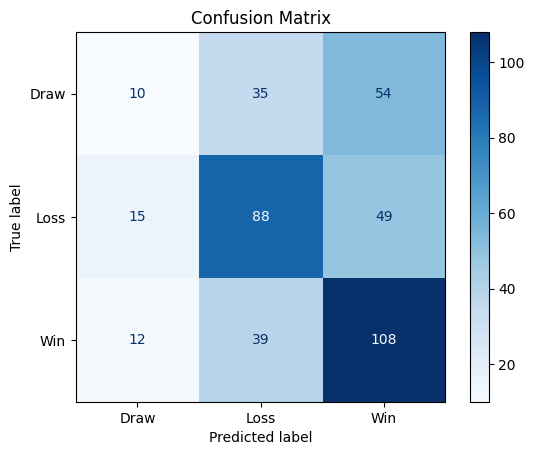

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_true = actual labels (0=loss, 1=draw, 2=win for example)
# y_pred = model predictions

cm = confusion_matrix(test_Y, voter_preds, labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Draw", "Loss", "Win"])
disp.plot(cmap="Blues", values_format="d")  # "d" for raw counts, ".2f" for proportions
plt.title("Confusion Matrix")
plt.show()


## Predicting upcoming matches

In [111]:
full_train_X = pd.concat([train_X_selected2, test_X_selected2])
full_train_Y = pd.concat([train_Y, test_Y])
normalized_sample_weights = compute_sample_weight('balanced', y=full_train_Y)

full_train_X_scaled = scaler.fit_transform(full_train_X)
predict_X = future_matches[features]
predict_X_scaled = scaler.transform(predict_X)

refined_voting_model.fit(full_train_X_scaled, full_train_Y, sample_weight=normalized_sample_weights)
voter_preds = refined_voting_model.predict(predict_X_scaled)
result_mapping_dict = {'0': 'Draw', '1': 'Loss', '2': 'Win'}
voter_preds = [result_mapping_dict.get(str(int(result))) for result in voter_preds]
team_mapping_dict2 = {value: key for key, value in team_mapping_dict.items()}
team_names = future_matches['Team_code'].map(team_mapping_dict2)
opp_names = future_matches['Opp_code'].map(team_mapping_dict2)
print(pd.DataFrame({'Team':team_names, 'Team_position': future_matches['Team_position'],
                    'Pred':voter_preds, 'Opponent': opp_names,
                    'Opp_position': future_matches['Opp_position']}))

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values